<a href="https://colab.research.google.com/github/nguyenhaphan1/Vietnam-Identity-Card-Id-Name-DoB-Extraction/blob/main/VIDInformationExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q ultralytics gitpython torch pillow>=10.3.0 requests vietocr

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import torch
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [4]:
config = Cfg.load_config_from_name('vgg_transformer')
# config['weights'] = './weights/transformerocr.pth'
config['cnn']['pretrained']=True
# config['device'] = 'cuda:0'
config['device'] = 'cpu'
detector = Predictor(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
corners_detecting_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/CCCD/corners_icon.pt', force_reload=True)
info_detecting_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/CCCD/info_detection.pt', force_reload=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 72.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
18533it [00:00, 25908.68it/s]
/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), whic

requirements: Ultralytics requirement ['pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 134.8 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0

requirements: AutoUpdate success ✅ 3.7s, installed 1 package: ['pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-8-24 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-8-24 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [5]:
def euclidean_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def calculate_center_point_of_bbox(bbox):
    x_min, y_min, x_max, y_max= bbox
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return (center_x, center_y)

def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1_min, x2_min)
    y_top = max(y1_min, y2_min)
    x_right = min(x1_max, x2_max)
    y_bottom = min(y1_max, y2_max)

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # Calculate the area of the intersection rectangle
    intersection_area = ( x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

def kth_smallest(arr, k):
    idx = list(range(len(arr)))
    idx = sorted(idx, key=lambda i: arr[i])
    return idx[k-1]

def draw_bbox(img, bboxes):
  for bbox in bboxes:
    x_min, y_min, x_max, y_max, _ = bbox
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
  return img

#Detect 4 corners and icon, then rotate the image into straight position
def rotate_image(image, center_of_icon, center_of_corners):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  distances_to_icon = []
  h, w = image.shape[:2]
  for point in center_of_corners:
    distances_to_icon.append(euclidean_distance(point, center_of_icon))

  nearest_point = center_of_corners[np.argmin(distances_to_icon)]
  tr, bl, br = 0, 0, 0

  xs_min = sorted(center_of_corners, key=lambda x: x[0])[0:4]

  if xs_min[0][1] < xs_min[1][1]:
    tl = xs_min[0]
    bl = xs_min[1]
  else:
    tl = xs_min[1]
    bl = xs_min[0]

  if xs_min[2][1] < xs_min[3][1]:
    tr = xs_min[2]
    br = xs_min[3]
  else:
    tr = xs_min[3]
    br = xs_min[2]

  orientated_corners = [tl, tr, br, bl]
  correct_corners = []
  temp = []

  for corner in enumerate(orientated_corners):
    idx = corner[0]
    if corner[1] == nearest_point:
      temp = list(range(idx, 4)) + list(range(0, idx))
      for i in temp:
        correct_corners.append(orientated_corners[i])

  pts1 = np.float32(correct_corners)
  pts2 = np.float32([[0, 0], [320, 0], [320, 320], [0, 320]])
  matrix = cv2.getPerspectiveTransform(pts1, pts2)
  result = cv2.warpPerspective(image, matrix, (320, 320))
  cv2_imshow(result)
  return result, True

def find_center_of_corners_and_icon(image, model):
  results = model(image, size=320)

  icon = 0
  icon_highest_conf = 0
  corners = []

  #Get bbox of detected object in the result
  for result in results.xyxy[0].tolist():
    # print(f'Result conf: {result[4]}')
    if result[4] < 0.7:
      continue
    if result[5] == 1 and result[4] > icon_highest_conf:
      icon_highest_conf = result[4]
      icon = result[0:5]
    elif result[5] == 0:
      corners.append(result[0:5])

  corners = NMS(corners)

  center_of_corners = []

  for corner in corners:
    center_of_corners.append(calculate_center_point_of_bbox(corner[0:4]))

  center_of_icon = calculate_center_point_of_bbox(icon[0:4])

  return center_of_corners, center_of_icon

def unit_vector(vector):
    #  Returns the unit vector of the vector.
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):

    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return math.acos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def cccd_rotating(image, model):

  return rotate_image(image, center_of_icon, center_of_corners)

def NMS(bboxes):

  bboxes = sorted(bboxes, key=lambda x: x[0])
  drop_list = []

  for id, bbox in enumerate(bboxes):
    for id_i, bbox_i in enumerate(bboxes[id+1:]):
      iou = calculate_iou(bbox[0:4], bbox_i[0:4])
      if iou > 0.1 and bbox[4] > bbox_i[4]:
        drop_list.append(bbox_i)
      elif iou > 0.1 and bbox[4] < bbox_i[4]:
        drop_list.append(bbox)

  bboxes_cleaned = [bbox for bbox in bboxes if bbox not in drop_list]

  return bboxes_cleaned

#Extract id, name, date of birth from id, name, date images using VietOCR model
def infor_extraction(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = model(image, size=320)

  if len(results.xyxy[0].tolist()) != 3:
    return None, None, None

  id_image = None
  name_image = None
  dob_image = None

  for result in results.xyxy[0].tolist():
    bbox = result[0:4]
    if result[-1] == 0:
      id_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    elif result[-1] == 1:
      name_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    elif result[-1] == 2:
      dob_image = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]

  return id_image, name_image, dob_image

def rotate_image_by_angle(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def find_last_corner(center_of_corners, center_of_icon):

  #sort corners ascending based on x_axis: x_corners[0] < x_corners[1] < x_corners[2]
  #-> if
  center_of_corners = sorted(center_of_corners, key=lambda x: x[0])

  #Case 1:missing corner locates on the left side of the image
  # -> x_icon < x_corners[1]
  if center_of_corners[1][0] > center_of_icon[0]:
    #Calculate the vector (tr, br)
    vector_1_2 = np.array(center_of_corners[2]) - np.array(center_of_corners[1])
    #Case 1.1: missing corner is top-left corner
    last_corner_1 = np.array(vector_1_2) + np.array(center_of_corners[0])
    last_corner_2 = np.array(center_of_corners[0]) - np.array(vector_1_2)

  #Case 2: misisng corner locates on the right side of the image
  #center_of_corners[1][0] < center_of_icon[0]
  #x_icon > x_corners[1]
  else:
    vector_0_1 = np.array(center_of_corners[1]) - np.array(center_of_corners[0])
    last_corner_1 = np.array(vector_0_1) + np.array(center_of_corners[2])
    last_corner_2 = np.array(center_of_corners[2]) - np.array(vector_0_1)

  return [tuple(last_corner_1), tuple(last_corner_2)]

In [13]:
def id_card_extracting(image_path):
  img = cv2.imread(image_path)
  img_w, img_h = img.shape[1], img.shape[0]
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  center_of_corners, center_of_icon = find_center_of_corners_and_icon(img, corners_detecting_model)
  id_image, name_image, dob_image = None, None, None

  # if the system can only detect 1 corner from the ID card, erase the corner and turn it into 0-corner-detected case
  if len(center_of_icon) != 0 and len(center_of_corners) == 1:
        center_of_corners = []

  #This system can deal with some cases when model detects 4, 3, and 0 corners of the Identity cards
  if len(center_of_corners) !=4 and len(center_of_corners) != 3 and len(center_of_corners) != 0:
    print("Can not extract enough information from this image: the detected corners differs from 0, 3 and 4")
  #Case 1: if the model successfully detect 4 corners of the Id card, just simply apply rotating and stretching the card
  elif len(center_of_corners) == 4:
    rotated_image, _ = rotate_image(img, center_of_icon, center_of_corners)
    rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
    cv2_imshow(rotated_image)
    id_image, name_image, dob_image = infor_extraction(rotated_image, info_detecting_model)

  #Case 2: if the model can not detect any corner of the ID card, it might fit the screen but is rotated in wrong position
  elif len(center_of_corners) == 0:
    #Assume that when the ID card is in right position, the Vietnam national icon locates at (0.143*W, 0.151*H).
    casual_icon_x_y = (0.143*img_w, 0.151*img_h)
    img_center = (img_w/2, img_h/2)

    vector_a = -np.array(casual_icon_x_y) + np.array(img_center)
    vector_b = -np.array(center_of_icon) + np.array(img_center)
    angle = np.degrees(angle_between(vector_a, vector_b))
    if img_center[0] + img_center[1] > 0:
      rotated_image = rotate_image_by_angle(img, angle)
    else:
      rotated_image = rotate_image_by_angle(img, -angle)
    rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
    cv2_imshow(rotated_image)
    id_image, name_image, dob_image = infor_extraction(rotated_image, info_detecting_model)
  #Case 3: if the model can only detect 3 corners of the card, try to find the missing corners and then rotate it with four corners.
  else:
    for last_corner in find_last_corner(center_of_corners, center_of_icon):
        rotated_image, _ = rotate_image(img, center_of_icon, center_of_corners + [last_corner])

        id_image, name_image, dob_image = infor_extraction(rotated_image, info_detecting_model)
        if id_image is not None and name_image is not None and dob_image is not None:
          break

  if id_image is None or name_image is None or dob_image is None:
    print("Can not extract enough information from this image: One of Id | Name | DoB might be None")
  else:

  #Recognize id, name, dob using model VietOCR
    pil_id = Image.fromarray(id_image)
    pil_name = Image.fromarray(name_image)
    pil_dob = Image.fromarray(dob_image)

    id = detector.predict(pil_id)
    name = detector.predict(pil_name)
    dob = detector.predict(pil_dob)

  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  ax[0].imshow(id_image)
  ax[1].imshow(name_image)
  ax[2].imshow(dob_image)
  plt.show()

  print(id)
  print(name)
  print(dob)

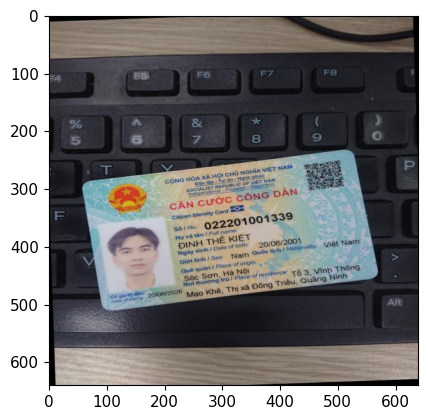

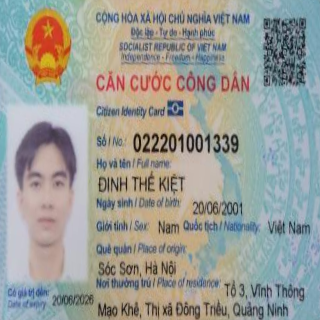

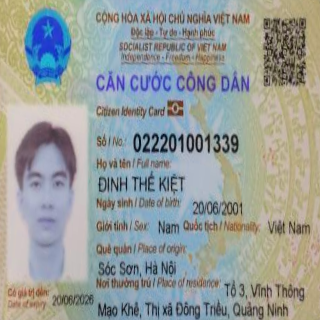

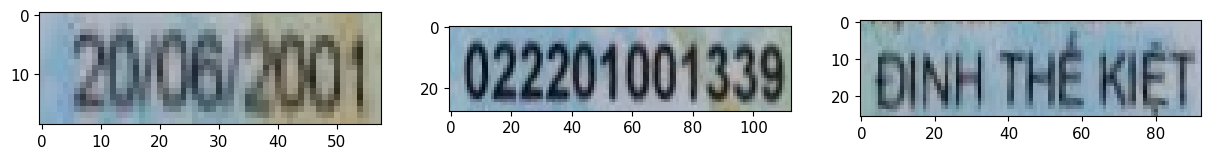

20/06/2001
022201001339
ĐINH THẾ KIỆT


In [20]:
image_path = '/content/drive/MyDrive/CCCD/data_for_prediction/additional_data_for_corners_detection/140.jpg'
id_card_extracting(image_path)